## Coupled dynamics - interaction effects

In [1]:
import os
from pathlib import Path
import numpy as np
from scipy.integrate import solve_ivp
import torch 

from matplotlib import pyplot as plt
import tikzplotlib

In [2]:
# Dynamics

def dzdt(t, z, Syx, Sxx, h, lr1, lr2):
    
    diff = Syx - h * Sxx * z[-1] * z[:-1]

    return np.concatenate([lr1 * z[-1] * diff, lr2 * (z[:-1] * diff).sum().reshape(1,)], axis=0)


def solve_dynamics(z0, t, Syx, Sxx, h, lr1, lr2): 
    
    z0 = np.ma.atleast_1d(z0)
    res = solve_ivp(dzdt, (0, max(t)), z0, t_eval=t, args = (Syx, Sxx, h, lr1, lr2))
    
    if not res["success"]:
        stat, msg = res.get("status"), res.get("message")
        print(f"ODE solver not successful. Termination {stat}. Message: {msg}")
    
    z = res["y"].squeeze()
    
    return np.transpose(z[:-1, :]), np.transpose(z[-1, :])
        

In [77]:
# Jacobian 

def J(z, Syx, Sxx, h, lr1, lr2):
    
    J0 = np.diag(np.concatenate((-lr1 * h * Sxx * z[-1]**2, -lr2 * h * (Sxx * z[:-1]).sum(keepdims=True))))
    d = Syx - 2 * h * Sxx * z[:-1] * z[-1]
    J0[:-1, -1] = lr1 * d
    J0[-1, :-1] = lr2 * d
    
    return J0

def v_assoc(J0):
    uv, sv, vtv = np.linalg.svd(J0)

    v1 = []
    v2 = []
    for i in range(sv.shape[0]):
        v1.append(np.linalg.norm(vtv[i, :][:-1]))
        v2.append(np.linalg.norm(vtv[i, :][-1]))

    v1 = np.array(v1)
    v2 = np.array(v2)
    vTrec = np.linalg.norm(np.stack((v1, v2)), axis=0)
    
    return sv, v1, v2, vTrec

In [146]:
l1, l2 = 4.0, 1.0
N = np.array([0.9, 0.1])
Syx = np.array([1.0, 1.0])
Sxx = np.array([l1, l2])

tau = 10000
res = 200
t_range = np.geomspace(1, tau, res)

hidden_dim = 100
lr1, lr2 = 0.001, 0.001

z0 = np.ones((3,)) * 0.001
Z1, Z2 = solve_dynamics(z0, t_range, Syx, Sxx, hidden_dim, lr1, lr2)

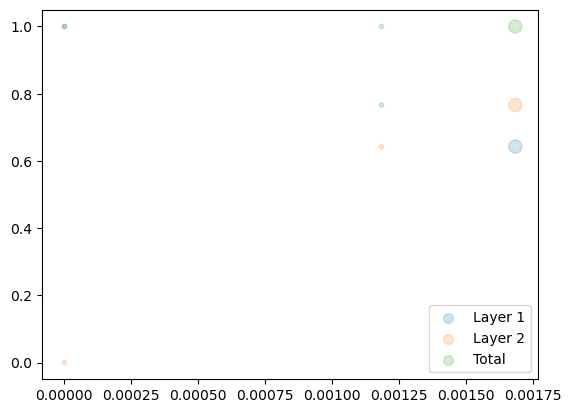

In [147]:
z0t = np.array([0.001, 0.001, 0.1])
J0 = J(z0, Syx, Sxx, hidden_dim, lr1, lr2)
S, v1, v2, v = v_assoc(J0)

# TODO: utöka till att du har 10 dim (9 dim bör bli exakt samma <- den första dim x 9?) Det syns ju inte...

S_ext = np.concatenate(([S[0]]*p, S[1:]))
v1_ext = np.concatenate(([v1[0]]*p, v1[1:]))
v2_ext = np.concatenate(([v2[0]]*p, v2[1:]))
v_ext = np.concatenate(([v[0]]*p, v[1:]))

sz = np.array([p, d-p, d-p]) * 10
plt.scatter(S, v1, s=sz, label="Layer 1", alpha=0.2)
plt.scatter(S, v2, s=sz, label="Layer 2", alpha=0.2)
plt.scatter(S, v, s=sz, label="Total", alpha=0.2)
plt.legend()
plt.show()


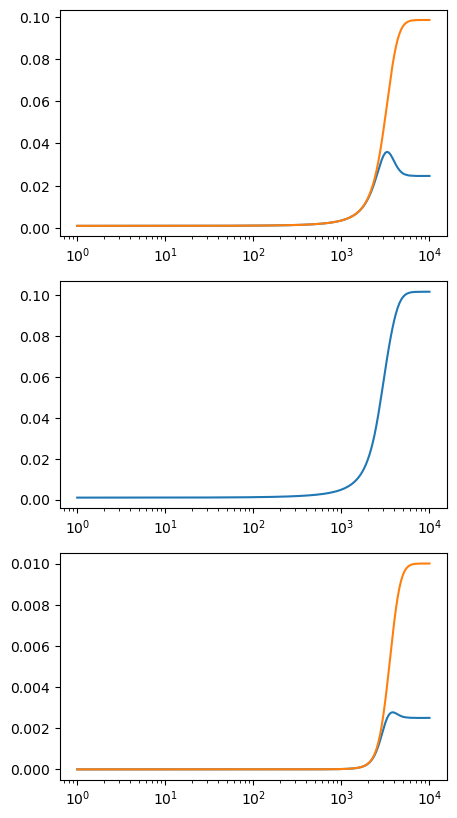

In [148]:
fig, ax = plt.subplots(3, 1, figsize=(5, 10))

ax[0].plot(t_range, Z1)
ax[1].plot(t_range, Z2)
ax[2].plot(t_range, Z2.reshape(-1, 1) * Z1)

for i in range(3):
    ax[i].set_xscale("log")

[0.0025 0.01  ]
[0.00125 0.0075 ]


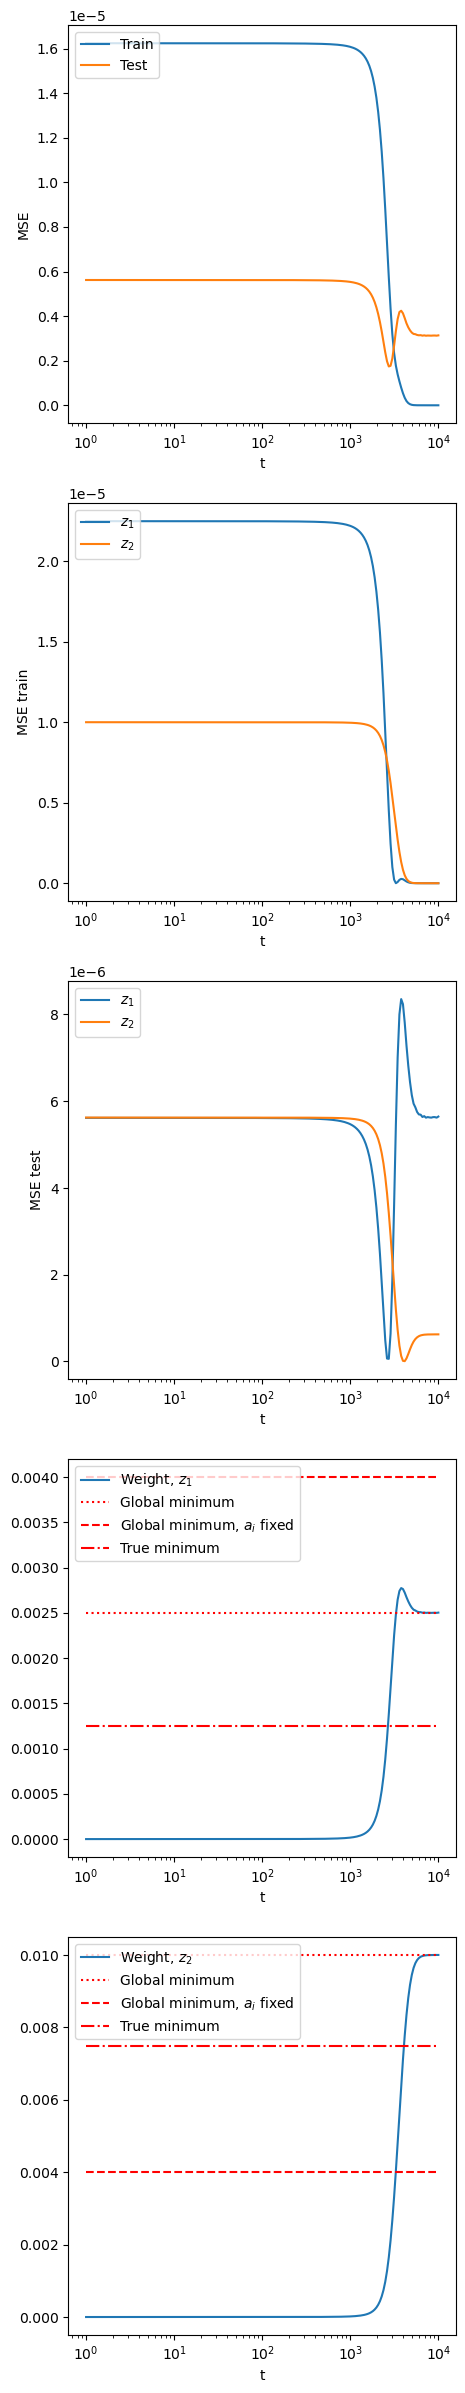

In [150]:
eps = np.array([0.25, 0.25])

w_min = Syx * (Sxx * hidden_dim)**(-1)
w_true = w_min - (eps / hidden_dim) * Sxx**(-0.5)

print(w_min)
print(w_true)

Z = Z2.reshape(-1, 1) * Z1

# Calculate MSE
mse_train = ((w_min - Z)**2) * N * Sxx
mse_test = ((w_true - Z)**2) * N * Sxx

res = 100
geo_samples = [int(i) for i in np.geomspace(1, tau - 1, num=res)]

fig, ax = plt.subplots(5, 1, figsize=(5, 30))

# Plot MSE
ax[0].plot(t_range, mse_train.mean(axis=-1), label="Train")
ax[0].plot(t_range, mse_test.mean(axis=-1), label="Test")
ax[1].plot(t_range, mse_train, label=[r"$z_1$", r"$z_2$"])
ax[2].plot(t_range, mse_test, label=[r"$z_1$", r"$z_2$"])

# Plot trajectories
ax[3].plot(t_range, Z[:, 0], label=r"Weight, $z_1$")
ax[4].plot(t_range, Z[:, 1], label=r"Weight, $z_2$")

# Add fixed points (first layer fixed)
Z2_opt = (Syx * z0[:-1]).sum() / (hidden_dim * (Sxx * z0[:-1]**2).sum()) 
Z_opt_2 = Z2_opt * z0[:-1] 

for i in range(2):
    ax[3 + i].hlines(w_min[i], min(t_range), max(t_range), color = 'r', linestyles='dotted', label=r"Global minimum")
    ax[3 + i].hlines(Z_opt_2[i], min(t_range), max(t_range), color = 'r', linestyles='dashed', label=r"Global minimum, $a_{i}$ fixed")
    ax[3 + i].hlines(w_true[i], min(t_range), max(t_range), color = 'r', linestyles='dashdot', label=r"True minimum")
    
    ax[3 + i].legend(loc=2)

ylabs = ["MSE", "MSE train", "MSE test", "", ""]
for i in range(ax.shape[0]):
    ax[i].set_xscale('log')
    ax[i].set_xlabel('t')
    ax[i].set_ylabel(ylabs[i])

    if i < 3:
        ax[i].legend(loc=2)


savedir = "res/interactions/"

if not os.path.exists(Path(savedir)):
    os.mkdir(Path(savedir))
    
plt.savefig(savedir + "same_lr_same_dir.png")
